<center><h1> CLASIFICACIÓN DE HOJAS </h1></center>

En el presente trabajo se planea desarrollar la tarea propuesta en la competencia de Kaggle [Leaf Classification](https://www.kaggle.com/c/leaf-classification). La cual consiste en predecir la especie a la que pertenecen las hojas de arboles dadas.<br/>
**Presentado Por:** Daniel Carvajal Patiño <br/>
**Presentado A:** Raúl Ramos Pollán
# 1. Librerías a usar:

In [1]:
#Importa librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage import io
from skimage import transform as tf
from sklearn.decomposition import PCA
from sklearn.cross_validation import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%run -i utils/Learn_curve.py
%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 2. Lectura de los datos del Dataset:
La competencia  [Leaf Classification](https://www.kaggle.com/c/leaf-classification) cuenta con 3 archivos `.csv` y un `.zip`. El zip contiene imágenes binarias de varias hojas de distintas especies. El primer csv denominado **train** contiene datos de la mayoría de las hojas del dataset, con las cuales se usarán para el entrenamiento de los algoritmos. El segundo archivo csv denominado **test** contiene datos del resto de hojas del dataset, usados para comprobar la efectividad del modelo. El tercero denominado **sample_sumbmission** es el archivo donde se guardaran las respuestas de los métodos y algoritmos a usar.

Se leen dichos archivos para observar que más contienen y luego se importan las imagenes.

In [2]:
#Lectura de archivos
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submsission = pd.read_csv('sample_submission.csv')

In [3]:
#Funcion ruta -- Auxiliar para ir cambiando la ruta de la imagen --
def ruta(num):
    return "images/"+str(num+1)+".jpg"    

In [4]:
#Lectura de las imagenes
set_images = np.array([io.imread(ruta(i)) for i in range(1584)])

# 3. Observación de los datos
`train` cuenta con 990 filas y 194 columnas, donde cada fila representa una hoja del dataset y cada columna representa la presencia de cierta característica en la hoja. La columna `id` es para asociar los datos con las imágenes, la columna `species` representa la especie a la cual pertenece la hoja.

In [5]:
#Exploracion de train
print(train.shape)
train.head()

(990, 194)


,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


En `test` las filas también representan la hojas del dataset y las columnas representan las caracteríticas de la hoja, cabe resaltar que las hojas de test no cuentan con la columna `species`, pues esa es la tarea a realizar, identificar a qué especie pertenecen las hojas.

In [6]:
#Exploracion de test
print(test.shape)
test.head()

(594, 193)


,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,12,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,13,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812


sample_submission es el formato de submission de la competencia

In [7]:
#Exploracion de sample_submission
sample_submsission.head()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
1,7,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
2,9,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
3,12,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
4,13,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101


Las imágenes al parecer son binarias y representan el contorno de las hojas, cabe indicar que el nombre de la imagen está asociado con la columna `id` tanto de train como de test.

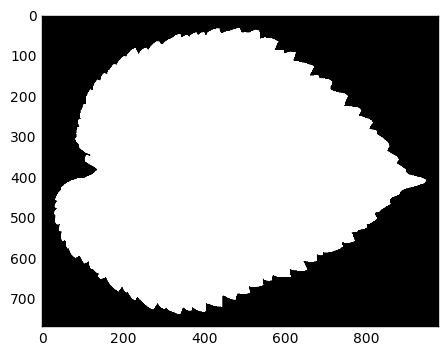

In [8]:
#Exploracion conjunto de imagenes
plt.imshow(set_images[random.randint(1, 1584)],cmap = plt.cm.Greys_r)

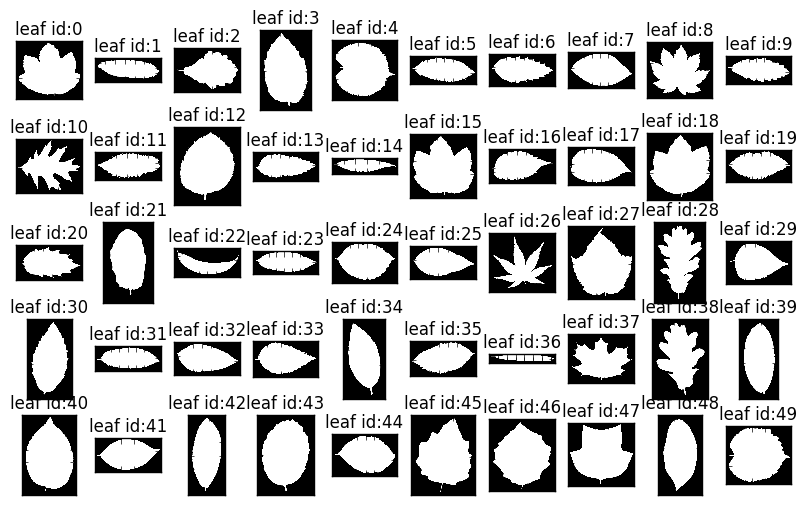

In [9]:
fig = plt.figure(figsize=(10,6))
for i in range(50):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(set_images[i], cmap = plt.cm.Greys_r)
    ax.set_title("leaf id:" + str(i))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

Al parecer las imágenes son binarias, aunque para comprobar esto se puede revisar el histograma de la imagen.

Cantidad de 0s: 114191.0
Cantidad de 1s: 264.0
Cantidad de 255s: 131187.0
Suma total: 245642.0
Cantidad de pixeles: 245642


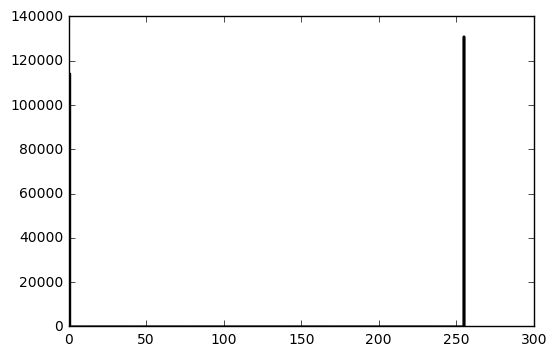

In [10]:
print("Cantidad de 0s:",plt.hist(set_images[0].flatten(), bins = 255)[0][0])
print("Cantidad de 1s:",plt.hist(set_images[0].flatten(), bins = 255)[0][1])
print("Cantidad de 255s:",plt.hist(set_images[0].flatten(), bins = 255)[0][254])
print("Suma total:", np.sum(plt.hist(set_images[0].flatten(), bins = 255)[0]))
print("Cantidad de pixeles:", set_images[0].shape[0]*set_images[0].shape[1])

Se observa que la imagen no es binaria, aunque la relación entre los 0, 255 y los 1 es muy grande, puede que esto afecte o no a la hora de clasificar.
# 4. Selección de datos para el entrenamiento
## 4.1 Datos
Se extrae los valores para el entrenamiento, separando la columna de especies y la de id.

In [5]:
#Extraccion de las clases
clases = np.unique(train['species'].values)

#Auxiliares para obtener y_train en base a clases
clases_num = np.array(range(99))
aux_y = np.array(train['species'].values)

data_y_train = np.ones(len(aux_y))
data_X_train = train.drop(['id', 'species'], axis = 1).values
data_X_test = test.drop(['id'], axis=1)

In [6]:
#Convierte los string de las clases a entero y los guarda en y_train
for i,n in enumerate(aux_y):
    for j,l in enumerate(clases):
        if (n == l):
            data_y_train[i] = j

In [7]:
data_y_train.shape, data_X_train.shape

((990,), (990, 192))

Debido a que los datos de test que brinda la competencia no vienen etiquetados, no se pueden hacer verificaciones locales sobre el entrenamiento de los algoritmos, por ende las datos de train se dividen en un nuevo train y test, el número 700 es escogido sin ningún criterio específico, más adelante se probaran otras técnicas como cross_validation para un mejor uso de selección del train y test.

In [8]:
#seleccion del train y test
X_train = data_X_train[:700]
X_test = data_X_train[700:]
y_train = data_y_train[:700]
y_test = data_y_train[700:]

## 4.2 Imágenes
Se realiza la misma división de datos para entrenamiento y test con las imágenes, es decir 700 para train y el resto para test. Debido a que las imágenes están completas, es decir las 1800 están seguidas, hay que seleccionar las de train y test usando la relación entre las imágenes y los datos la cual es la columna `id` de las tablas.

In [9]:
id_train = train['id'].values
id_test = test['id'].values

In [10]:
aux_img = np.array([set_images[i-1] for i in id_train])
X_train_img = aux_img[:700]
X_test_img = aux_img[700:]

In [11]:
test_img = np.array([set_images[i-1] for i in id_test])

## 4.3 Histograma
En la clasificación de imágenes no necesariamente se requieren usar las imágenes, la clasificación puede realizarse usando descriptores de las imágenes, y los histogramas son considerados descriptores. Por ende se calculan los histogramas para usarlos más adelante en un proceso de entrenamiento.

In [ ]:
hit_img = [plt.hist(i.flatten(), bins = 255)[0] for i in aux_img]

In [ ]:
hit_img_train = [plt.hist(i.flatten(), bins = 255)[0] for i in X_train_img]

In [ ]:
hit_img_test = [plt.hist(i.flatten(), bins = 255)[0] for i in X_test_img]

**Nota:** Por cuestiones de hardware no se usarán los histogramas. El proceso es demasiado pesado para la maquina con la que estoy realizando el trabajo.
## 4.4 Redimension
Si se desea las imágenes pueden ser usadas en la clasificación, pero los algoritmos necesitan que los datos que se les entregan tengan las mismas dimensiones, por ende si se quieren usar las imágenes hay que redimensionarlas.

In [12]:
resize_img = []
resize_img_train = []
resize_img_test = []
resize_test = []

In [13]:
for i in aux_img:
    resize_img.append(tf.resize(i,(300,300)).flatten())

In [14]:
for i in test_img:
    resize_test.append(tf.resize(i,(300,300)).flatten())

In [15]:
for i in X_train_img:
    resize_img_train.append(tf.resize(i,(300,300)).flatten())
    
for i in X_test_img:
    resize_img_test.append(tf.resize(i,(300,300)).flatten())

In [16]:
np.array(resize_img).shape, data_y_train.shape

((990, 90000), (990,))

## 4.5 PCA

In [17]:
pca = PCA(n_components=60)

In [18]:
# PCA Datos
Xp = pca.fit_transform(data_X_train)

# PCA Imágenes
Xp_img = pca.fit_transform(resize_img)

# PCA datos e Imágenes
data_resize = np.concatenate((data_X_train,resize_img), axis = 1)
Xp_data_img = np.concatenate((Xp,Xp_img),axis = 1)
print(data_X_train.shape, np.array(resize_img).shape, data_resize.shape)

(990, 192) (990, 90000) (990, 90192)


# 5. Entrenamiento de Algoritmos
En esta sección se entrenarán y probarán varios algoritmos de clasificación, el entrenamiento se probara tanto con los datos, las imágenes, los descriptores, componentes y combinaciones de los mismos. Luego se usarán el algoritmo y combinación de datos que mejor score presente para realizar una submission.
## 5.1 [GaussianNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

In [21]:
gaussian_model = GaussianNB()

In [28]:
# Datos
score_data_g = np.mean(cross_val_score(gaussian_model, data_X_train, data_y_train, cv=5))
print("Score Datos =================================> ", score_data_g)

# Imagenes redimensionadas
score_resize_g = np.mean(cross_val_score(gaussian_model, resize_img,data_y_train, cv=5))
print("Score Imagenes Redimesionadas: ==============> ", score_resize_g)

# Datos e Imágenes redimensionadas
score_data_resize_g = np.mean(cross_val_score(gaussian_model, data_resize,data_y_train, cv=5))
print("Score Datos e Imágenes: =====================> ", score_data_resize_g)

# PCA de Datos
score_data_pca_g = np.mean(cross_val_score(gaussian_model, Xp,data_y_train, cv=5))
print("Score PCA Datos: ============================> ", score_data_pca_g)

# PCA de Imágenes
score_img_pca_g = np.mean(cross_val_score(gaussian_model, Xp_img,data_y_train, cv=5))
print("Score PCA Imágenes: =========================> ", score_img_pca_g)

# PCA Datos e Imágenes
score_pca_data_img_g = np.mean(cross_val_score(gaussian_model, Xp_data_img,data_y_train, cv=5))
print("Score PCA Datos e Imágenes: =================> ", score_pca_data_img_g)

Score Datos =================================>  0.550505050505
Score Imagenes Redimesionadas: ==============>  0.367676767677
Score Datos e Imágenes: =====================>  0.367676767677
Score PCA Datos: ============================>  0.90101010101
Score PCA Imágenes: =========================>  0.551515151515
Score PCA Datos e Imágenes: =================>  0.937373737374


In [19]:
digits = load_digits()
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
y_lim = (0, 1.01)

<module 'matplotlib.pyplot' from 'C:\\Program Files\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

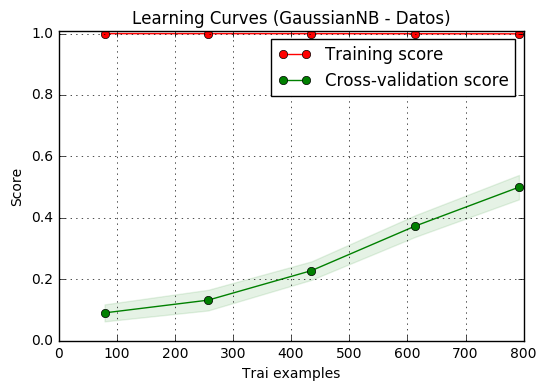

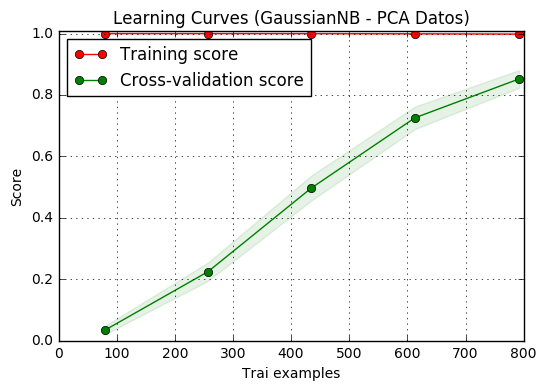

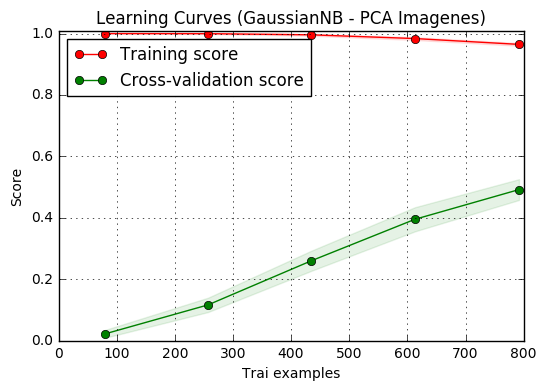

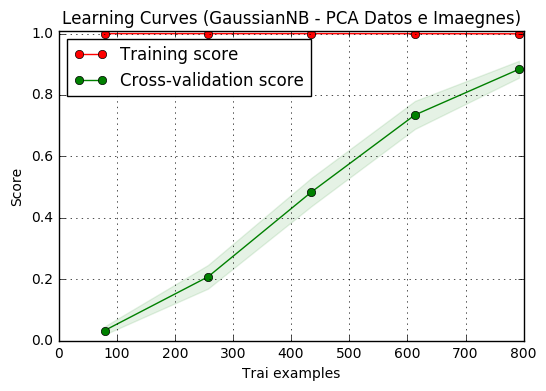

In [35]:
# Datos
title = "Learning Curves (GaussianNB - Datos)"
plot_learning_curve(gaussian_model, title, data_X_train, data_y_train, ylim=y_lim, cv=cv, n_jobs=4)

# PCA Datos
title = "Learning Curves (GaussianNB - PCA Datos)"
plot_learning_curve(gaussian_model, title, Xp, data_y_train, ylim=y_lim, cv=cv, n_jobs=4)

# PCA Imágenes
title = "Learning Curves (GaussianNB - PCA Imagenes)"
plot_learning_curve(gaussian_model, title, Xp_img, data_y_train, ylim=y_lim, cv=cv, n_jobs=4)

# PCA Datos e Imágenes
title = "Learning Curves (GaussianNB - PCA Datos e Imaegnes)"
plot_learning_curve(gaussian_model, title, Xp_data_img, data_y_train, ylim=y_lim, cv=cv, n_jobs=4)

## 5.2 [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [36]:
svc_model = SVC()

In [37]:
# Datos
score_data_svc = np.mean(cross_val_score(svc_model, data_X_train, data_y_train, cv=5))
print("Score Datos =================================> ", score_data_svc)

# Imágenes
score_resize_svc = np.mean(cross_val_score(svc_model, resize_img,data_y_train, cv=5))
print("Score Imágenes redimensionadas ==============> ", score_resize_svc)

# Datos e Imágenes
score_data_resize_svc = np.mean(cross_val_score(svc_model, data_resize,data_y_train, cv=5))
print("Score Datos e Imágenes: =====================> ", score_data_resize_svc)

# PCA Datos
score_data_pca_svc = np.mean(cross_val_score(svc_model, Xp,data_y_train, cv=5))
print("Score PCA Datos: ============================> ", score_data_pca_svc)

#PCA Imágenes
score_img_pca_svc = np.mean(cross_val_score(svc_model, Xp_img,data_y_train, cv=5))
print("Score PCA Imágenes: =========================> ", score_img_pca_svc)

#PCA Datos e Imágenes
score_pca_data_img_svc = np.mean(cross_val_score(svc_model, Xp_data_img,data_y_train, cv=5))
print("Score PCA Datos e Imágenes: =================> ", score_pca_data_img_svc)

Score Datos =================================>  0.79696969697
Score Imágenes redimensionadas ==============>  0.506060606061
Score Datos e Imágenes: =====================>  0.506060606061
Score PCA Datos: ============================>  0.791919191919
Score PCA Imágenes: =========================>  0.246464646465
Score PCA Datos e Imágenes: =================>  0.285858585859


In [36]:
svc_model = SVC(kernel="poly", degree=2)

In [ ]:
# Datos
score_data_svc = np.mean(cross_val_score(svc_model, data_X_train, data_y_train, cv=5))
print("Score Datos =================================> ", score_data_svc)

# Imágenes
score_resize_svc = np.mean(cross_val_score(svc_model, resize_img,data_y_train, cv=5))
print("Score Imágenes redimensionadas ==============> ", score_resize_svc)

# Datos e Imágenes
score_data_resize_svc = np.mean(cross_val_score(svc_model, data_resize,data_y_train, cv=5))
print("Score Datos e Imágenes: =====================> ", score_data_resize_svc)

# PCA Datos
score_data_pca_svc = np.mean(cross_val_score(svc_model, Xp,data_y_train, cv=5))
print("Score PCA Datos: ============================> ", score_data_pca_svc)

#PCA Imágenes
score_img_pca_svc = np.mean(cross_val_score(svc_model, Xp_img,data_y_train, cv=5))
print("Score PCA Imágenes: =========================> ", score_img_pca_svc)

#PCA Datos e Imágenes
score_pca_data_img_svc = np.mean(cross_val_score(svc_model, Xp_data_img,data_y_train, cv=5))
print("Score PCA Datos e Imágenes: =================> ", score_pca_data_img_svc)

Score Datos =================================>  0.79696969697
Score Imágenes redimensionadas ==============>  0.506060606061
Score Datos e Imágenes: =====================>  0.506060606061
Score PCA Datos: ============================>  0.791919191919
Score PCA Imágenes: =========================>  0.246464646465
Score PCA Datos e Imágenes: =================>  0.285858585859


## 5.3 [KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [38]:
knc_model_5 = KNeighborsClassifier(5)

In [40]:
# Datos
score_data_knc_5 = np.mean(cross_val_score(knc_model_5, data_X_train, data_y_train, cv=5))
print("Score Datos =================================> ", score_data_knc_5)

# Imágenes 
score_resize_knc_5 = np.mean(cross_val_score(knc_model_5, resize_img,data_y_train, cv=5))
print("Score Imágenes redimensionadas ==============> ", score_resize_knc_5)

# Datos e Imágenes
score_data_resize_knc_5 = np.mean(cross_val_score(knc_model_5, data_resize,data_y_train, cv=5))
print("Score Datos e Imágenes: =====================> ", score_data_resize_knc_5)

# PCA Datos
score_data_pca_knc_5 = np.mean(cross_val_score(knc_model_5, Xp,data_y_train, cv=5))
print("Score PCA Datos: ============================> ", score_data_pca_knc_5)

# PCA Imágenes
score_img_pca_knc_5 = np.mean(cross_val_score(knc_model_5, Xp_img,data_y_train, cv=5))
print("Score PCA Imágenes: =========================> ", score_img_pca_knc_5)

# PCA Datos e Imágenes
score_pca_data_img_knc_5 = np.mean(cross_val_score(knc_model_5, Xp_data_img,data_y_train, cv=5))
print("Score PCA Datos e Imágenes: =================> ", score_pca_data_img_knc_5)

Score Datos =================================>  0.862626262626
Score Imágenes redimensionadas ==============>  0.475757575758
Score Datos e Imágenes: =====================>  0.476767676768
Score PCA Datos: ============================>  0.857575757576
Score PCA Imágenes: =========================>  0.522222222222
Score PCA Datos e Imágenes: =================>  0.522222222222


In [42]:
knc_model_10 = KNeighborsClassifier(10)

In [43]:
# Datos
score_data_knc_10 = np.mean(cross_val_score(knc_model_10, data_X_train, data_y_train, cv=5))
print("Score Datos =================================> ", score_data_knc_10)

# Imágenes 
score_resize_knc_10 = np.mean(cross_val_score(knc_model_10, resize_img,data_y_train, cv=5))
print("Score Imágenes redimensionadas ==============> ", score_resize_knc_10)

# Datos e Imágenes
score_data_resize_knc_10 = np.mean(cross_val_score(knc_model_10, data_resize,data_y_train, cv=5))
print("Score Datos e Imágenes: =====================> ", score_data_resize_knc_10)

# PCA Datos
score_data_pca_knc_10 = np.mean(cross_val_score(knc_model_10, Xp,data_y_train, cv=5))
print("Score PCA Datos: ============================> ", score_data_pca_knc_10)

# PCA Imágenes
score_img_pca_knc_10 = np.mean(cross_val_score(knc_model_10, Xp_img,data_y_train, cv=5))
print("Score PCA Imágenes: =========================> ", score_img_pca_knc_10)

# PCA Datos e Imágenes
score_pca_data_img_knc_10 = np.mean(cross_val_score(knc_model_10, Xp_data_img,data_y_train, cv=5))
print("Score PCA Datos e Imágenes: =================> ", score_pca_data_img_knc_10)

Score Datos =================================>  0.80404040404


KeyboardInterrupt: 

## 5.4 [DecisionTreeClassifier()](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [ ]:
dtc_model = DecisionTreeClassifier()

In [130]:
# Datos
score_data_dtc = np.mean(cross_val_score(dtc_model, data_X_train, data_y_train, cv=5))
print("Score Datos =================================> ", score_data_dtc)

# Imágenes
score_resize_dtc = np.mean(cross_val_score(dtc_model, resize_img,data_y_train, cv=5))
print("Score Imágenes redimensionadas ==============> ", score_resize_dtc)

# Datos e Imágenes
score_data_resize_dtc = np.mean(cross_val_score(dtc_model, data_resize,data_y_train, cv=5))
print("Score Datos e Imágenes: =====================> ", score_data_resize_dtc)

# PCA Datos
score_data_pca_dtc = np.mean(cross_val_score(dtc_model, Xp,data_y_train, cv=5))
print("Score PCA Datos: ============================> ", score_data_pca_dtc)

# PCA Imágenes
score_img_pca_dtc = np.mean(cross_val_score(dtc_model, Xp_img,data_y_train, cv=5))
print("Score PCA Imágenes: =========================> ", score_img_pca_dtc)

# PCA Datos e Imágenes
score_pca_data_img_dtc = np.mean(cross_val_score(dtc_model, Xp_data_img,data_y_train, cv=5))
print("Score PCA Datos e Imágenes: =================> ", score_pca_data_img_dtc)

score:  0.694949494949


In [ ]:
dtc_model = DecisionTreeClassifier( max_depth=2)

In [130]:
# Datos
score_data_dtc = np.mean(cross_val_score(dtc_model, data_X_train, data_y_train, cv=5))
print("Score Datos =================================> ", score_data_dtc)

# Imágenes
score_resize_dtc = np.mean(cross_val_score(dtc_model, resize_img,data_y_train, cv=5))
print("Score Imágenes redimensionadas ==============> ", score_resize_dtc)

# Datos e Imágenes
score_data_resize_dtc = np.mean(cross_val_score(dtc_model, data_resize,data_y_train, cv=5))
print("Score Datos e Imágenes: =====================> ", score_data_resize_dtc)

# PCA Datos
score_data_pca_dtc = np.mean(cross_val_score(dtc_model, Xp,data_y_train, cv=5))
print("Score PCA Datos: ============================> ", score_data_pca_dtc)

# PCA Imágenes
score_img_pca_dtc = np.mean(cross_val_score(dtc_model, Xp_img,data_y_train, cv=5))
print("Score PCA Imágenes: =========================> ", score_img_pca_dtc)

# PCA Datos e Imágenes
score_pca_data_img_dtc = np.mean(cross_val_score(dtc_model, Xp_data_img,data_y_train, cv=5))
print("Score PCA Datos e Imágenes: =================> ", score_pca_data_img_dtc)

score:  0.694949494949


## 5.5 [LinearDiscriminantAnalysis](http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)

In [ ]:
lda_model = LinearDiscriminantAnalysis()

### 5.5.1 Datos

In [148]:
# Datos
score_data_lda = np.mean(cross_val_score(lda_model, data_X_train, data_y_train, cv=5))
print("Score Datos =================================> ", score_data_lda)

# Imágenes
score_resize_lda = np.mean(cross_val_score(lda_model, resize_img,data_y_train, cv=5))
print("Score Imágenes redimensionadas ==============> ", score_resize_lda)

# Datos e Imágenes
score_data_resize_lda = np.mean(cross_val_score(lda_model, data_resize,data_y_train, cv=5))
print("Score Datos e Imágenes: =====================> ", score_data_resize_lda)

# PCA Datos
score_data_pca_lda = np.mean(cross_val_score(lda_model, Xp,data_y_train, cv=5))
print("Score PCA Datos: ============================> ", score_data_pca_lda)

# PCA Imágenes
score_img_pca_lda = np.mean(cross_val_score(lda_model, Xp_img,data_y_train, cv=5))
print("Score PCA Imágenes: =========================> ", score_img_pca_lda)

# PCA Datos e Imágenes
score_pca_data_img_lda = np.mean(cross_val_score(lda_model, Xp_data_img,data_y_train, cv=5))
print("Score PCA Datos e Imágenes: =================> ", score_pca_data_img_lda)

score:  0.974747474747


C:\Program Files\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files\Anaconda3\lib\site-packages\s

# 6. VotingClassifier

In [ ]:
class VotingClassifier:
    
    def __init__(self):
        self._estimators = [GaussianNB(), DecisionTreeClassifier(), LogisticRegression(), SVC(kernel="poly", degree=2)]
        
    def fit(self, X,y):
        for estimator in self._estimators:
            estimator.fit(X,y)
            
    def predict(self, X):
        preds = np.zeros(X.shape[0])
        for estimator in self._estimators:
            preds += estimator.predict(X)
            
        preds = (preds>(len(self._estimators)/2.)).astype(int)
        return preds
    
    def score(self, X,y):
        return np.sum(self.predict(X)==y)*1./len(X)
    
    def get_params(self, deep=None):
        return dict()

In [ ]:
vc = VotingClassifier()
vc.fit(Xp_data_img,data_y_train)
print "ensemble score", np.mean(cross_val_score(vc, X,y, cv=10))

# 7. Tabla comparativa

In [162]:
modelos = ['GaussianNB', 'SVC', 'KNeighborsClassifier','DecisionTreeClassifier','LinearDiscriminantAnalysis']
scores = ["Datos", "Imágenes redimensionadas", "Datos + Imágenes redimensionadas","PCA Datos", "PCA Imagenes", "PCA Datos + PCA Iamgenes"]

scores_g = [score_data_g, score_resize_g, score_data_resize_g, score_data_pca_g, score_img_pca_g, score_pca_data_img_g]
scores_svc = [score_data_svc, score_resize_svc, score_data_resize_svc, score_data_pca_svc, score_img_pca_svc, score_pca_data_img_svc]
scores_knc =  [score_data_knc, score_resize_knc, score_data_resize_knc, score_data_pca_knc, score_img_pca_knc, score_pca_data_img_knc]
scores_dtc =  [score_data_dtc, score_resize_dtc, score_data_resize_dtc, score_data_pca_dtc, score_img_pca_dtc, score_pca_data_img_dtc]
scores_lda = [score_data_lda, score_resize_lda, score_data_resize_lda, score_data_pca_lda, score_img_pca_lda, score_pca_data_img_lda]

dict_pandas = {'GaussianNB': scores_g, 'SVC': scores_svc, 'KNeighborsClassifier': scores_knc, 'DecisionTreeClassifier': scores_dtc, 'LinearDiscriminantAnalysis': scores_lda}

comparacion = pd.DataFrame(dict_pandas, columns=modelos, index= scores)

In [163]:
comparacion

,GaussianNB,SVC,KNeighborsClassifier,DecisionTreeClassifier,LinearDiscriminantAnalysis
Datos,0.550505,0.796970,0.862626,0.694949,0.974747
Imágenes redimensionadas,0.367677,0.506061,0.475758,0.275758,0.388889
Datos + Imágenes redimensionadas,0.367677,0.506061,0.476768,0.648485,0.484848
PCA Datos,0.896970,0.791919,0.857576,0.539394,0.964646
PCA Imagenes,0.552525,0.242424,0.521212,0.293939,0.606061
PCA Datos + PCA Iamgenes,0.942424,0.285859,0.521212,0.528283,0.979798


In [166]:
comparacion.max()

GaussianNB                    0.942424
SVC                           0.796970
KNeighborsClassifier          0.862626
DecisionTreeClassifier        0.694949
LinearDiscriminantAnalysis    0.979798
dtype: float64

In [167]:
comparacion.max().max()

0.97979797979797989

# 8. Conclusiones

1. Se logra el objetivo del trabajo con muy buenos resultados ya que como se puede observar se consigue un score de 0.97.
2. Se usaron varios clasificadores para encontrar cual es el que mejor se adapta a este dataset en particular, como resultado el LinearDiscriminantAnalysis es el clasificador que mejor se adapta a las distintas representaciones de datos que se utilizaron.
3. Aunque varios clasificadores mostraron malos resultados en comparación con el LinearDiscriminantAnalysis, estos resultados se podrían mejorar usando otra representación de los datos o jugando con los parámetros del algoritmo.
4. Las imágenes redimensionadas no son buenas a la hora de entrenar algoritmos, como se demuestra, es mejor usar un descriptor las mismas como lo son los componentes PCA.
5. PCA es una muy buena opción para representar datos e imágenes para el entrenamiento de algoritmos, pues en la mayoría de los clasificadores, los scores mejoraron con su uso.
6.  Combinando el PCA de los datos y el PCA de las imágenes se consigue una mejor representación
7. En general los clasificadores se demoraban mas usando las imagenes redimensiondas y presentan peores resultados.
es mejor usar el votating
Se puede observar que el mayor score se obtuvo entrenando un LinearDiscriminantAnalysis con los PCA de los datos y las imágenes
